# STA208 Final Project

## Predicting Marine Organism Conservation Status

_________________
__Author:__ Evan Batzer 

__Date:__ 6/2/2020

### 0. Background

Biodiversity loss is a major focus of environmental management in the 21st century -- extinctions of plant and animal species is estimated to be 10 - 100 times greater than in the past 10 million years, largely as a function of human activity. 

Several organizations have attempted to provide global-level databases to help monitor and predict biodiversity loss. Chief among these is the __IUCN__, the International Union for the Conservation of Nature, which publishes a continually updating list of species known as the _Red List_.

![IUCN](../images/IUCN_logo.png)

The _Red List_ is established as a useful tool for conservation decision-making, but is difficult to maintain. There are estimated to be roughly 8.7 Million species on the planet, each of which must be assessed by a panel of experts to be included on the _Red List_. 

Species are given a conservation designation ranging from "Least Concern" to "Extinct".

![IUCN_labels](../images/IUCN_classes.png)

However, species given conservation designations on the _Red List_ often share similar characteristics -- size, reproductive capacity, human use for agriculture, etc. These features may be effective classifiers of species with known conservation designations and may help speed the process of generating and updating IUCN databases.

__Core Question:__ How well can conservation status be classified by species characteristics?

### 1. Assembling Dataset

#### 1.1 Querying FishBase API

FishBase is a global database containing information on the characteristics and distribution of roughly 34,000 fish species. These characteristics are thought to be good predictors of species IUCN status. Large, slow-growing species, for example, may be more likely to go extinct than smaller, faster-growing species with limited commercial value.

Data is open access and generally well-documented, but provided at several levels of organization. Because IUCN categorization is made at the species level, meaningful features must be extracted, cleaned, and aggregated at an appropriate scale.

In [1]:
import requests
import pandas as pd
import numpy as np
from os import path
from plotnine import *
from xgboost import XGBRFClassifier
from matplotlib import pyplot as plt
import copy

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [2]:
def extract_fishbase(table):
    
    tablename = "https://fishbase.ropensci.org/" + table
    query = requests.get(tablename + "?limit=5000")
    n_obs = query.json()['count']
    df = pd.DataFrame(query.json()['data'])

    while(df.shape[0] < n_obs):
        query = requests.get(tablename + "?limit=5000&offset=" + str(df.shape[0]))
        tempdf = pd.DataFrame(query.json()['data'])
        df = df.append(tempdf)
        
    print("Table '%s' - Returned %s rows of %s features" % (table, df.shape[0], df.shape[1]))  
    return(df)

In [3]:
# All available species
taxaTable = extract_fishbase("taxa")

# General species characteristics
speciesTable = extract_fishbase("species")

# Species ecology (habitat type, prey, etc.)
ecologyTable = extract_fishbase("ecology")

# Ecosystem characteristics
ecosystemTable = extract_fishbase("ecosystem")

# Maturity / reproduction
reproTable = extract_fishbase("maturity")

Table ''taxa' - Returned 34342 rows of 14 features
Table ''species' - Returned 34342 rows of 102 features
Table ''ecology' - Returned 11897 rows of 142 features
Table ''ecosystem' - Returned 151869 rows of 47 features
Table ''maturity' - Returned 8733 rows of 35 features


__Aggregating the ecosystem table:__ 

Rather than containing information on a species-by-species basis, the ecosystem table contains features that are organized by different habitats. Because models will be constructed at the species level (not subspecies or individual habitat), I aggregate these based on metric. Certain features are binary (present in freshwater/saltwater), so are converted to one-hot labels and summed per species -- some fish may be present in both types of water, for example. Others are summed or averaged, such as total range or average depth.

In [4]:
ecosys_cols = ["Speccode", "Salinity", "Area", "SizeRef", "Climate", "AverageDepth", "MaxDepth", "TempSurface", "TempDepth"]

ecosys_subset = ecosystemTable[ecosys_cols]

area_agg = ecosys_subset.groupby("Speccode")["Area"].sum()
ecosys_subset[["AverageDepth", "TempSurface", "TempDepth"]] = ecosys_subset[["AverageDepth", "TempSurface", "TempDepth"]].apply(pd.to_numeric, errors='coerce')
ATT_agg = ecosys_subset.groupby("Speccode")["AverageDepth", "TempSurface", "TempDepth"].mean()

ecosys_subset["Climate"] = ecosys_subset["Climate"].str.lower().fillna("None")
climate_onehot = label_binarize(ecosys_subset["Climate"], classes = ecosys_subset["Climate"].unique()[0:5])
climate_agg =  pd.DataFrame(climate_onehot, columns=ecosys_subset["Climate"].unique()[[0,1,2,3,4]])

ecosys_subset['Salinity'] = ecosys_subset['Salinity'].str.lower().fillna("None")
salinity_onehot = label_binarize(ecosys_subset['Salinity'], classes = ecosys_subset['Salinity'].unique()[0:3])
salinity_agg =  pd.DataFrame(salinity_onehot, columns=ecosys_subset['Salinity'].unique()[0:3])

cat_full = pd.DataFrame(ecosys_subset["Speccode"]).join([salinity_agg, climate_agg]).groupby('Speccode').sum()
cat_full = (cat_full > 1) * 1

ecosys_full = cat_full.join([area_agg, ATT_agg])
ecosys_full.reset_index(inplace = True)

C:\Users\ebatz\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\ebatz\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
C:\Users\ebatz\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\ebatz\anaconda3\lib

Other tables contain considerable overlap in columns, particularly related to error checking or source material. Here, I subset each table to the relevant set of characteristics from each.

In [5]:
# Columns for the taxonomy dataset
taxa_cols = ["SpecCode", "Genus", "Species", "Family", "Order", "Class"]
taxa_subset = taxaTable[taxa_cols].set_index("SpecCode")

# Columns for the species dataset
spec_cols = ["SpecCode", "Vulnerability", "Length", "Weight", "Importance", "UsedforAquaculture",
             "UsedasBait", "Aquarium", "GameFish", "Dangerous"]

# Columns for the reproduction dataset
reproTable.rename(columns={"Speccode": "SpecCode"}, inplace = True)
repro_cols = ["SpecCode", "AgeMatMin", "AgeMatMin2", "LengthMatMin", "LengthMatMin2"]
repro_subset = reproTable[repro_cols].set_index("SpecCode")

repro_subset = repro_subset.groupby("SpecCode").mean()
AgeMin = repro_subset[["AgeMatMin","AgeMatMin2"]].min(axis = 1)
LengthMin = repro_subset[["LengthMatMin","LengthMatMin2"]].min(axis = 1)
repro_subset = pd.concat([pd.Series(AgeMin), pd.Series(LengthMin)],axis = 1)
repro_subset.columns = ["Age_Maturity", "Length_Maturity"]

# Columns for the ecology dataset
eco_cols = ["SpecCode","Neritic", "SupraLittoralZone", "Saltmarshes", "LittoralZone", "TidePools", "Intertidal", "SubLittoral", 
"Caves", "Oceanic","Epipelagic", "Mesopelagic", "Bathypelagic", "Abyssopelagic", "Hadopelagic", "Estuaries", "Mangroves",
"MarshesSwamps", "CaveAnchialine", "Stream", "Lakes","Cave",'DietTLu']

# Binaries are coded as -1,0 in this data - converting to 1,0
eco_subset = ecologyTable[eco_cols].set_index("SpecCode")
eco_subset[eco_cols[1:-1]] = (eco_subset[eco_cols[1:-1]] == -1) * 1
eco_subset = eco_subset.groupby("SpecCode").sum()

spec_subset = speciesTable[spec_cols]
spec_subset["GameFish"] = (speciesTable["GameFish"] == -1) * 1

# Binarizing labels
spec_bin = pd.concat(
    [pd.get_dummies(spec_subset["Importance"], prefix='Imp'),
     pd.get_dummies(spec_subset["Aquarium"], prefix='Aquarium'),
     pd.get_dummies(spec_subset["UsedforAquaculture"], prefix='Aquaculture'),
     pd.get_dummies(spec_subset["UsedasBait"], prefix='Bait').iloc[:,1:],
     pd.get_dummies(spec_subset["Dangerous"], prefix='Danger')],
    axis = 1)

spec_subset = pd.concat([spec_subset.drop(columns = ["Importance", "Aquarium", "UsedforAquaculture", "UsedasBait", "Dangerous"]),
           spec_bin],
          axis = 1).set_index("SpecCode")

C:\Users\ebatz\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### 1.2 Joining Tables

In [6]:
features = taxa_subset.join([spec_subset, eco_subset, repro_subset, ecosys_full])
features.head()

,Genus,Species,Family,Order,Class,Vulnerability,Length,Weight,GameFish,Imp_,...,brackish,tropical,subtropical,polar,temperate,boreal,Area,AverageDepth,TempSurface,TempDepth
SpecCode,,,,,,,,,,,,,,,,,,,,,
48039,Abyssocottus,elochini,Abyssocottidae,Scorpaeniformes,Actinopterygii,40.29,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48040,Abyssocottus,gibbosus,Abyssocottidae,Scorpaeniformes,Actinopterygii,35.49,14.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47208,Abyssocottus,korotneffi,Abyssocottidae,Scorpaeniformes,Actinopterygii,32.97,12.6,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48048,Asprocottus,abyssalis,Abyssocottidae,Scorpaeniformes,Actinopterygii,38.21,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48049,Asprocottus,herzensteini,Abyssocottidae,Scorpaeniformes,Actinopterygii,33.02,11.5,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
features.to_csv("data/fishbase_features.csv")

#### 1.3 Creating IUCN Labels

In [8]:
if not path.exists('data/IUCN.csv'):

    try:
        from urllib.request import urlretrieve
    except ImportError:
        from urllib import urlretrieve

    urlretrieve('https://drive.google.com/u/0/uc?id=0B9_zEbZIPqtIVXJ1VVpEMGNxdnc&export=download', 
                'data/IUCN.csv')

# Reading in dataset -- correcting some encoding errors    
IUCN_labels = pd.read_csv('data/IUCN.csv', encoding = "ISO-8859-1", engine='python')

In [9]:
IUCN_labels = IUCN_labels[["Class", 'Order', 'Family', 'Genus', 'Species', 'Red List status']]

IUCN_labels[["Class", 'Order', 'Family']] = IUCN_labels[["Class", 'Order', 'Family']].apply(lambda x: x.astype(str).str.capitalize())
fish_classes = ['Actinopterygii', 'Chondrichthyes','Sarcopterygii','Cephalaspidomorphi']

IUCN_subset = IUCN_labels.loc[IUCN_labels['Class'].isin(fish_classes)]

IUCN_labels.head()

,Class,Order,Family,Genus,Species,Red List status
0,Magnoliopsida,Fabales,Leguminosae,Abarema,cochliocarpos,LC
1,Magnoliopsida,Fabales,Leguminosae,Abarema,commutata,LR/lc
2,Magnoliopsida,Fabales,Leguminosae,Abarema,curvicarpa,LC
3,Aves,Caprimulgiformes,Trochilidae,Abeillia,abeillei,LC
4,Mammalia,Rodentia,Muridae,Abeomelomys,sevia,LC


In [10]:
full_df = pd.merge(features, IUCN_subset.iloc[:,3:],  
         how='left', 
         left_on=['Genus', 'Species'], 
         right_on = ['Genus', 'Species'])

__Note:__ Some issues with taxonomy cause issues with the join. ~150 labels need to have corrected Genus/Species labels to match the current version of FishBase. Will have to correct manually later on.

In [11]:
data_labelled = full_df[full_df["Red List status"].notna()]
data_labelled.shape

(9268, 75)

Updated versions of the RedList dataset are not yet available for download. The data I am using is a few years old, and contains secondary categories between LC - "Least Concern" and NT - "Near Threatened" -- "LR/lc" and "LR/nt". There are relatively few observations of this class, so I'll just lump them into the LC class.

In [12]:
data_labelled["Red List status"] = data_labelled["Red List status"].str.replace("LR.+", "LC")
data_labelled["Red List status"] = pd.Categorical(data_labelled["Red List status"],
               categories = ["LC", "NT", "VU", "EN", "CR", "EW", "EX"],
              ordered=True)

C:\Users\ebatz\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ebatz\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Removing species that are "endangered" or "extinct in the wild"

In [13]:
import numpy as np
data_labelled = data_labelled[~data_labelled["Red List status"].isin(["EX", "EW"])]
data_labelled.to_csv("data/data_labelled.csv")

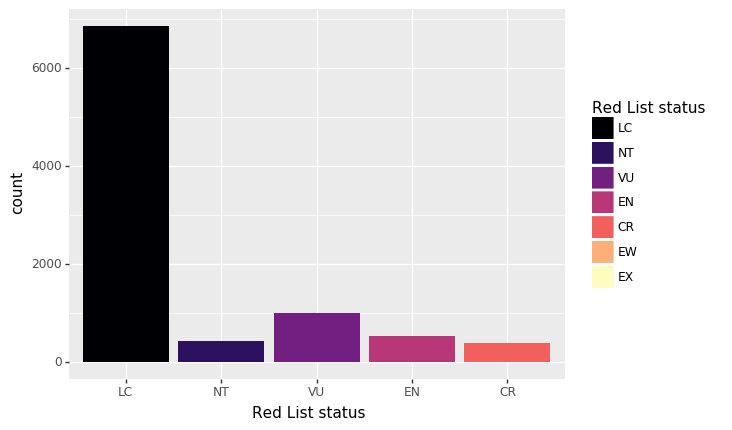

<ggplot: (-9223371921828598056)>

In [14]:
(ggplot(data_labelled,
       aes(x = 'Red List status',
          fill = 'Red List status')) + 
 geom_bar() +
scale_fill_cmap_d("magma"))

### 2. Binary Classification -- "Least Concern" vs. Others

The simplest way to look at this data is through a binary classification between the "Least Concern" class and all others that reflect some degree of vulnerability to extinction. This approach is common in published studies that have examined this problem. 

In [51]:
data_labelled = pd.read_csv("data/data_labelled.csv")

features = data_labelled.drop(["Species", "Vulnerability", "Red List status", "Genus", 
                               "Family", "Order", "Class", "Unnamed: 0", "Speccode"], axis = 1)

features["Area"].replace(0, np.nan, inplace=True)

features_bin = pd.get_dummies(features, columns=[])
features_bin = features_bin.drop("Imp_ ", axis = 1)

features_bin.head()

,Length,Weight,GameFish,Imp_commercial,Imp_highly commercial,Imp_minor commercial,Imp_of no interest,Imp_of potential interest,Imp_subsistence fisheries,Aquarium_commercial,...,brackish,tropical,subtropical,polar,temperate,boreal,Area,AverageDepth,TempSurface,TempDepth
0,24.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,33.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,45.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,244296764.0,4100.0,20.05,17.375
3,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,85029540.0,3600.0,21.55,17.550


In [52]:
scaler = StandardScaler()

# Standardizing quantitative columns
quantcols = ['Length', 'Weight','DietTLu','Area','AverageDepth','TempSurface','TempDepth', 'Age_Maturity', 'Length_Maturity']
quant_std = pd.DataFrame(scaler.fit_transform(features_bin[quantcols]),
                           columns = quantcols)

# Standardized dataset (lots of NA's!)
features_std = pd.concat([quant_std, features_bin.drop(quantcols, axis = 1)], axis = 1)
features_std.head()

,Length,Weight,DietTLu,Area,AverageDepth,TempSurface,TempDepth,Age_Maturity,Length_Maturity,GameFish,...,Lakes,Cave,freshwater,saltwater,brackish,tropical,subtropical,polar,temperate,boreal
0,-0.139854,NaN,-0.455351,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.017366,NaN,-0.455351,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.226993,NaN,-0.455351,1.052117,0.489980,0.009435,0.154410,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.314337,NaN,-0.455351,-0.493121,-0.090207,0.308765,0.197353,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [53]:
x_full = features_std # Standardized predictors
y_full = data_labelled["Red List status"] == "LC" * 1 # Classes - whether "Least Concern" or not 
y_full = 1 - y_full

In [54]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 8, 10, 20],
        'n_estimators': [100,200,300,500,600,800,1000]
        }

xgb_classifier = XGBRFClassifier(learning_rate=0.02,
                    objective='binary:logistic',
                    silent=True, 
                    nthread=1)

folds = 5
param_comb = 25

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

In [55]:
# Initializing cross-validation search
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=params, 
                                   n_iter=param_comb, scoring='accuracy', n_jobs=4, 
                                   cv=skf.split(x_full,y_full), verbose=3, random_state=0)

# Running randomized CV search
random_search.fit(x_full, y_full)

random_search.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 15.5min finished


0.7748572963653969

In [56]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
x_full = x_full.to_numpy()

bestmod_1 = copy.copy(random_search.best_estimator_)

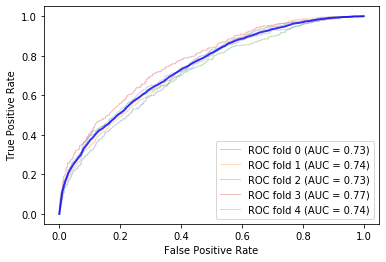

In [57]:
fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(x_full,y_full)):
    bestmod_1.fit(x_full[train], y_full[train])
    viz = plot_roc_curve(bestmod_1, x_full[test], y_full[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

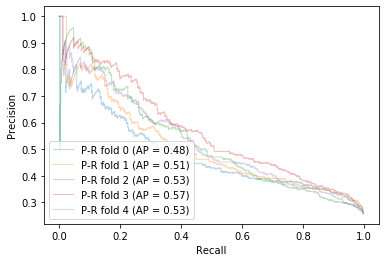

In [61]:
prec = []
rec = []
mean_prec = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(x_full,y_full)):
    bestmod_1.fit(x_full[train], y_full[train])
    viz = plot_precision_recall_curve(bestmod_1, x_full[test], y_full[test],
                         name='P-R fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_prec, viz.precision, viz.recall)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

### 3. Imputing Missing Features

Ideally, imputation could be constructed using phylogenetic information from different species -- the genetic relationships that describe how similar species are to one another on an evolutionary scale. Given the scope of this dataset, however, a full *time-calibrated phylogeny of all fish species* is not available. 

However, many features are predictive of one another. Larger fish, for example, are likely to have longer times to maturity and slower reproductive rates. Approches like K-Nearest Neighbors or Random Forest based imputation are known to be [effective imputers for species trait data](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/2041-210X.12232) in certain circumstances.

In [22]:
# imputer = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=5), 
#                            add_indicator=True)

# data_imputed = imputer.fit_transform(features_std)

In [23]:
# imputed_cols = features_std.columns.append(features_std.columns[features_std.isnull().any()] + "Missing")
# data_imputed = pd.DataFrame(data_imputed, columns = imputed_cols)
# data_imputed.to_csv("data/imputed_features.csv")

In [24]:
pd.read_csv('data/imputed_features.csv').head()

,Unnamed: 0,Length,Weight,DietTLu,Area,AverageDepth,TempSurface,TempDepth,Age_Maturity,Length_Maturity,...,LakesMissing,CaveMissing,freshwaterMissing,saltwaterMissing,brackishMissing,tropicalMissing,subtropicalMissing,polarMissing,temperateMissing,borealMissing
0,0,-0.139854,-0.068625,-0.455351,0.492794,0.420358,0.803895,1.040876,-0.638508,-0.527541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.017366,-0.068981,-0.455351,-0.726752,0.188283,0.107216,0.042759,-0.638293,-0.462761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.226993,-0.066908,-0.455351,1.052117,0.489980,0.009435,0.154410,-0.418321,-0.335671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,-0.509042,-0.069449,-0.455351,-1.291229,-4.194679,-0.469493,-1.512993,-0.434417,-0.693165,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4,0.314337,-0.065984,-0.455351,-0.493121,-0.090207,0.308765,0.197353,-0.638508,-0.367560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4. Binary Classification - Imputed Data

In [62]:
x_full = pd.read_csv('data/imputed_features.csv') # Standardized predictors
y_full = data_labelled["Red List status"] == "LC" * 1 # Classes - whether "Least Concern" or not 
y_full = 1 - y_full 

# Initializing cross-validation search
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=params, 
                                   n_iter=param_comb, scoring='accuracy', n_jobs=4, 
                                   cv=skf.split(x_full,y_full), verbose=3, random_state=0)

# Running randomized CV search
random_search.fit(x_full, y_full)

random_search.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 21.1min finished


0.783114033016083

In [63]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
x_full = x_full.to_numpy()

bestmod_2 = copy.copy(random_search.best_estimator_)

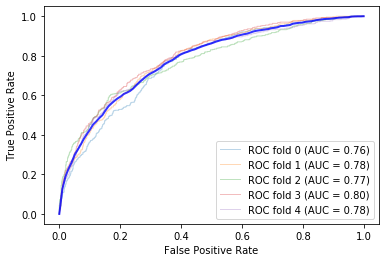

In [65]:
fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(x_full,y_full)):
    bestmod_2.fit(x_full[train], y_full[train])
    viz = plot_roc_curve(bestmod_2, x_full[test], y_full[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

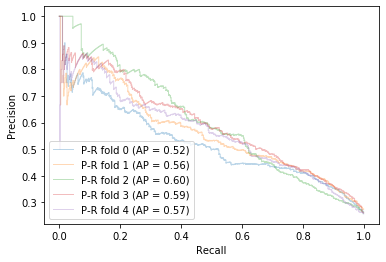

In [66]:
prec = []
rec = []
mean_prec = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(x_full,y_full)):
    bestmod_2.fit(x_full[train], y_full[train])
    viz = plot_precision_recall_curve(bestmod_2, x_full[test], y_full[test],
                         name='P-R fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_prec, viz.precision, viz.recall)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

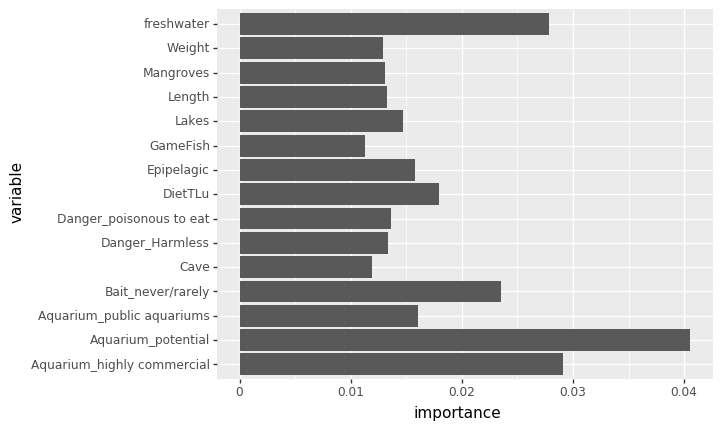

<ggplot: (-9223371921825499340)>

In [67]:
imputed_cols = features_std.columns.append(features_std.columns[features_std.isnull().any()] + "Missing")
var_imp = pd.concat([pd.Series(bestmod_2.feature_importances_),
             pd.Series(imputed_cols)],axis = 1)
var_imp.columns=["importance", "variable"]
var_imp.sort_values('importance')

(ggplot(aes(y = 'importance',
            x = 'variable'),
       (var_imp.iloc[:-40,].sort_values('importance', ascending=False))[:15]) +
 geom_bar(stat = "identity") +
 coord_flip())

### 5. Ordinal Classification - Conservation Status as a pseudo-numeric scale

The key next step in this project is to adapt an ordinal classification method to this data. Several approaches seem possible.

* One approach is to adapt our learning objective to a binary classifier, like SVM, by decomposing ordinal classes into a series of sequential tasks:

* $P(y_i = LC) = 1 - P(y_i > LC)$ 
* $P(y_i = NT) = P(y_i > LC) - P(y_i > NT)$ 

$\dots$
* $P(y_i = CR) = P(y_i > CR)$

Assigned classes can be generated by the maximum probability for each label.

* Other options include using existing ordinal regression libraries, such as `mord`, that include implementations of different ordinal regression algorithms.